<a href="https://colab.research.google.com/github/ManasaCherukupally1/Manasa_INFO5731_Spring2023/blob/main/Cherukupally_In_class_exercise_04_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/28/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Write your code here
import pandas as pd
import random
import re
import matplotlib.pyplot as plt

from gensim import corpora, models
import nltk
nltk.download('stopwords')
import gensim
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy
!python3 -m spacy download en_core_web_sm


# Sample messages
messages = [
    "Congratulations! You've won a free iPhone. Claim your prize now.",
    "Hi, just wanted to check in and see how you're doing. Let's catch up soon.",
    "Get rich quick with our amazing money-making scheme! Guaranteed success!",
    "I'll be there in 10 minutes. Do you need anything from the store?",
    "URGENT: Your bank account has been compromised. Click the link to secure it.",
    "Thank you for your email. I've attached the report you requested.",
    "Meet hot singles in your area tonight! Click to chat with them now.",
    "I hope you had a great weekend. Let's plan a dinner outing this Friday.",
    "You've been selected for a $1,000,000 prize. Send us your personal details.",
    "Can you pick up some groceries on your way home from work."
]

# Create labels (0 for genuine, 1 for spam)
labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

# Cleaning text
def clean_text_messages(text):
    # Convert to lowercase
    text = text.lower()
    # Remove new line characters and extra whitespaces
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    return text

cleaned_messages = [clean_text_messages(message) for message in messages]


data = {
    "Message": cleaned_messages,
    "Label": labels
}

df = pd.DataFrame(data)
print(df)
data = df.Message.values.tolist()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2023-11-05 09:12:24.566578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 09:12:24.566633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 09:12:24.566664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 09:12:25.832326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 65.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
                                             Message  La

In [3]:
# Create a list of tokenized words
tokenized_text = [simple_preprocess(message) for message in data]

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Creating model for  bigram
bigram = Phrases(tokenized_text, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

#Remove stopwords
def remove_stopwords_text(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
#Make Bigrams
def make_bigrams_text(texts):
    return [bigram_mod[doc] for doc in texts]

# Do lemmatization_text
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization_text(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_output

# Remove Stop Words
data_words_nostopwords = remove_stopwords_text(tokenized_text)

# Form Bigrams
data_of_words_bigrams = make_bigrams_text(data_words_nostopwords)

# Lemmatization
data_after_lemmatized = lemmatization_text(data_of_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_str= [' '.join(tokens) for tokens in data_after_lemmatized]

print(data_after_lemmatized[:1])

# Create a dictionary and corpus
corpora_dict = corpora.Dictionary(data_after_lemmatized)
corpus = [corpora_dict.doc2bow(text) for text in data_after_lemmatized]

[['congratulation', 've', 'free', 'iphone', 'claim', 'prize']]


Optimal number of topics: 8


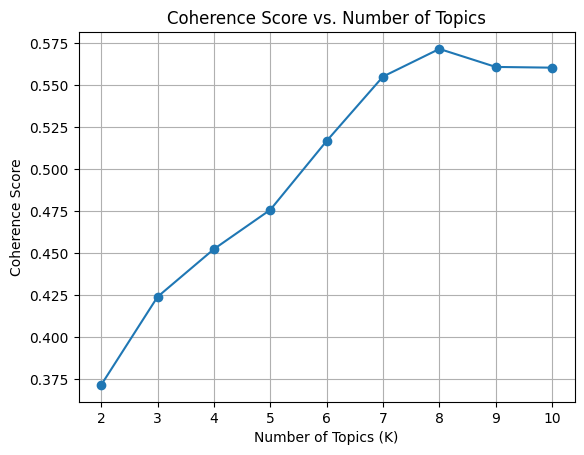

In [3]:
from gensim.models import CoherenceModel

#calculate the coherence score for LDA
def calculate_coherence_score(corpus, dictionary, texts, k):
    lda_model = models.LdaModel(corpus, num_topics=k, id2word=dictionary)
    coh_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coh_model.get_coherence()

# Find the optimal coherence
best_coherence = 0
best_k = 0
coherence_scores=[]

for k in range(2, 11):  # You can adjust the range as needed
    coh = calculate_coherence_score(corpus, corpora_dict, data_after_lemmatized, k)
    coherence_scores.append(coh)
    if coh > best_coherence:
        best_coherence = coh
        best_k = k

print(f"Optimal number of topics: {best_k}")

# Plot the coherence scores
plt.plot(range(2, 11), coherence_scores, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

In [4]:
#initialize the LDA model
lda_model = models.LdaModel(corpus, num_topics=best_k, id2word=corpora_dict)

# Get the topics and the top words from it
topics_from_text = lda_model.print_topics(num_topics=best_k, num_words=5)

for topic in topics_from_text:
    print(topic)


(0, '0.080*"want" + 0.080*"let" + 0.080*"see" + 0.080*"re" + 0.080*"catch"')
(1, '0.087*"prize" + 0.087*"free" + 0.087*"claim" + 0.087*"iphone" + 0.087*"ve"')
(2, '0.042*"guarantee" + 0.042*"get" + 0.042*"quick" + 0.042*"scheme" + 0.042*"success"')
(3, '0.102*"store" + 0.102*"need" + 0.102*"ill" + 0.102*"minute" + 0.011*"prize"')
(4, '0.018*"ve" + 0.018*"let" + 0.018*"prize" + 0.018*"grocery" + 0.018*"secure"')
(5, '0.085*"click" + 0.045*"ve" + 0.045*"hot" + 0.045*"area" + 0.045*"report"')
(6, '0.018*"ve" + 0.018*"prize" + 0.018*"let" + 0.018*"secure" + 0.018*"tonight"')
(7, '0.087*"ve" + 0.087*"personal" + 0.087*"detail" + 0.087*"select" + 0.087*"send"')


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

Optimal number of dimensions (topics) based on LSA coherence score: 6


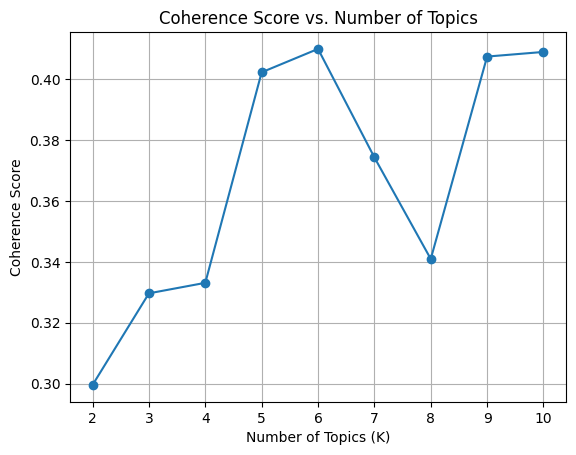

In [8]:
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

# Get optimal coherence scores
best_coh = 0
best_k = 0
coherence_scores = []

for k in range(2, 11):  # You can adjust the range as needed
    lsi_model = models.LsiModel(corpus, id2word=corpora_dict, num_topics=k)
    lsi_topic_matrix = lsi_model[corpus]

    # Calculate coherence score for LSA
    coh_model = CoherenceModel(model=lsi_model, texts=data_after_lemmatized, dictionary=corpora_dict, coherence='c_v')
    coherence = coh_model.get_coherence()
    coherence_scores.append(coherence)

    if coherence > best_coh:
        best_coh = coherence
        best_k = k

print(f"Optimal number of dimensions (topics) based on LSA coherence score: {best_k}")

# Plot the coherence scores
plt.plot(range(2, 11), coherence_scores, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

In [10]:
from gensim import corpora, models

# Train the LsiModel
lsi_model = models.LsiModel(corpus, id2word=corpora_dict, num_topics=best_k)

# Get the top terms for each topic
for i in range(best_k):
    topic_terms_lsi = lsi_model.show_topic(i, topn=5)  # Get the top 5 terms for each dimension
    top_terms_lsi = [term for term, score in topic_terms_lsi]
    print(f"Topic {i + 1}: {', '.join(top_terms_lsi)}")


Topic 1: ve, prize, congratulation, iphone, claim
Topic 2: get, success, guarantee, moneymaking, scheme
Topic 3: let, outing, great, plan, weekend
Topic 4: click, area, hot, chat, meet
Topic 5: re, want, soon, catch, check
Topic 6: report, thank, request, attach, email


## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [11]:
!pip install lda2vec

In [12]:
pip install pyLDAvis

In [13]:
from lda2vec import Lda2Vec, preprocess, Corpus

#tokenize the text
tokenized_texts = data_lemmatized

#initialize the corpus
corpus = Corpus()
corpus.update(tokenized_texts)

# Create the Lda2Vec model
lda2vec_model = Lda2Vec(corpus, num_topics=10, num_words=10)

# Train the model
lda2vec_model.train(50, workers=4)

# Calculate optimal coherence score
coherence_scores = []
for k in range(2, 11):
    lda2vec_model.num_topics = k
    lda2vec_model.train(50, workers=4)
    cohmodel = CoherenceModel(model=lda2vec_model)
    coherence_score = cohmodel.get_coherence()
    coherence_scores.append((k, coherence_score))

# Find the best K based on the highest coherence score
best_k, best_coherence = max(coherence_scores, key=lambda x: x[1])

print(f"Optimal number of topics: {best_k}, Coherence Score: {best_coherence}")

# Plot the coherence scores for Lda2Vec
plt.plot(range(2, 11), coherence_scores, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

# Set the model to the best K
lda2vec_model.num_topics = best_k
lda2vec_model.train(50, workers=4)

# Get and print the topics
topics = lda2vec_model.get_topics()
for i, topic in enumerate(topics):
    words, weights = zip(*topic)
    print(f"Topic {i + 1}: {', '.join(words)}")

ImportError: ignored

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [14]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:35,389 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:42,094 - BERTopic - Reduced dimensionality
2023-11-05 09:16:42,111 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:42,783 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:47,555 - BERTopic - Reduced dimensionality
2023-11-05 09:16:47,566 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:48,029 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:50,338 - BERTopic - Reduced dimensionality
2023-11-05 09:16:50,350 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:50,732 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:53,037 - BERTopic - Reduced dimensionality
2023-11-05 09:16:53,048 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:53,463 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:55,760 - BERTopic - Reduced dimensionality
2023-11-05 09:16:55,771 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:56,139 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:16:58,904 - BERTopic - Reduced dimensionality
2023-11-05 09:16:58,919 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:16:59,530 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:17:04,330 - BERTopic - Reduced dimensionality
2023-11-05 09:17:04,345 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:17:04,929 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:17:07,708 - BERTopic - Reduced dimensionality
2023-11-05 09:17:07,715 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:17:08,085 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:17:10,397 - BERTopic - Reduced dimensionality
2023-11-05 09:17:10,408 - BERTopic - Clustered reduced embeddings


Optimal number of topics: 2, Coherence Score: 1.0


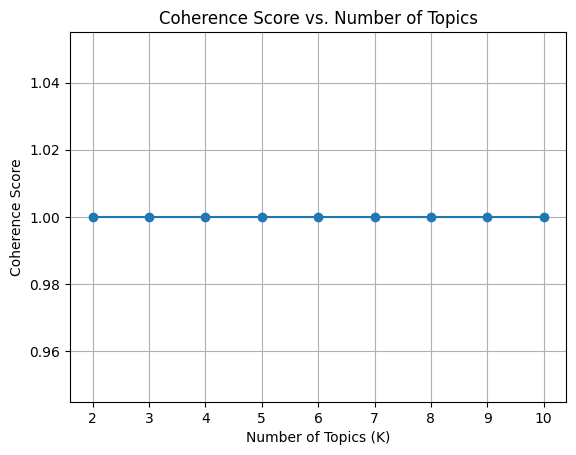

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-05 09:17:11,027 - BERTopic - Transformed documents to Embeddings
2023-11-05 09:17:13,324 - BERTopic - Reduced dimensionality
2023-11-05 09:17:13,335 - BERTopic - Clustered reduced embeddings


Number of topics: 3


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1,-1_link_compromise_secure_account,"[link, compromise, secure, account, click, , ,...",[account compromise click link secure]
1,0,5,0_let_minute_area_want,"[let, minute, area, want, tonight, store, soon...","[meet hot single area tonight click chat, hope..."
2,1,4,1_ve_prize_guarantee_iphone,"[ve, prize, guarantee, iphone, success, send, ...",[get rich quick amazing moneymaking scheme gua...


In [6]:
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

# Initialize BERTopic
best_k = 0
best_coh = -1
coherence_score=[]
for k in range(2, 11):  # You can adjust the range as needed
    bert_topic_model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 2)
    topics, _ = bert_topic_model.fit_transform(data_str)

    # Calculate coherence score
    coh_model = CoherenceModel(model=bert_topic_model, texts=data_after_lemmatized, dictionary=corpora_dict, coherence='c_v')
    coherence = coh_model.get_coherence()
    coherence_score.append(coherence)
    if coherence > best_coh:
        best_coh = coherence
        best_k = k
print(f"Optimal number of topics: {best_k}, Coherence Score: {best_coh}")

# Plot the coherence scores
plt.plot(range(2, 11), coherence_score, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

#create model with new topic size
bert_topic_model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 2)
topics, probs = bert_topic_model.fit_transform(data_str)

#print topics
freq = bert_topic_model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

In [7]:
bert_topic_model.get_topic(0)


[('let', 0.15985968485322471),
 ('minute', 0.10148408125744743),
 ('area', 0.10148408125744743),
 ('want', 0.10148408125744743),
 ('tonight', 0.10148408125744743),
 ('store', 0.10148408125744743),
 ('soon', 0.10148408125744743),
 ('single', 0.10148408125744743),
 ('see', 0.10148408125744743),
 ('re', 0.10148408125744743)]

In [8]:
bert_topic_model.topics_[:10]

[1, 0, 1, 0, -1, 1, 0, 0, 1, 0]

In [9]:
#visualize barchat
bert_topic_model.visualize_barchart(top_n_topics=6)

In [10]:
#visualize hierarchy
bert_topic_model.visualize_hierarchy(top_n_topics=6)

In [11]:
#visualize heatmap
bert_topic_model.visualize_heatmap(n_clusters=1, width=500, height=500)

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [12]:
from nltk.corpus.reader import documents
from torch.nn import factory_kwargs
# Write your answer here (no code needed for this question)
'''
The algorithm we need to select among four depends on the various factors like
 data and the goals we need to acquire using it.
 LDA (Latent Dirichlet Allocation): LDA provides easily interpretable topics that
 will be easily understandable by users. LDA identifies the topic in the documents
 based on the co-occurance patterns of the words.

 example: if spam messages were taken LDA will given topics like Phishing, Fradulent
 etc based on pattern

LSA (Latent Semantic Analysis):LSA is used to provide the semantic understanding
about the terms and the documents which will be used to find relationships of
topic.It identifies the association among the topics.

example: if spam messages were taken, LSA will give 'prize money' for 'Reward'

LDA2VEC: It is the combination of LDA and Word2Vec. It is used for capturing word
level context.It is used to provide topics by understanding in which contect words
are used.
example: if spam messages were taken, LDA2VEC may identify words like phishing,
 fradulent by identifying context

BERT (Bidirectional Encoder Representations from Transformers):
BERT is used to understand the sematics and the context involved in the documents
though it is not a specifically topic modelling algorithm. BERT works well in
capturing contexual information than for summarization.

example: if spam messages were taken, BERT can identify 'Phishing' or
'Personal Info' from message context.

If we want to get clear topics LDA is best. If we want the sematic relationship
LSA is best. If we want interpretability with context LDA2VEC is better.
BERT requires additional processing for categorization but gives good results.
'''

"\nThe algorithm we need to select among four depends on the various factors like\n data and the goals we need to acquire using it.\n LDA (Latent Dirichlet Allocation): LDA provides easily interpretable topics that\n will be easily understandable by users. LDA identifies the topic in the documents\n based on the co-occurance patterns of the words.\n\n example: if spam messages were taken LDA will given topics like Phishing, Fradulent\n etc based on pattern\n\nLSA (Latent Semantic Analysis):LSA is used to provide the semantic understanding\nabout the terms and the documents which will be used to find relationships of\ntopic.It identifies the association among the topics.\n\nexample: if spam messages were taken, LSA will give 'prize money' for 'Reward'\n\nLDA2VEC: It is the combination of LDA and Word2Vec. It is used for capturing word\nlevel context.It is used to provide topics by understanding in which contect words\nare used. \nexample: if spam messages were taken, LDA2VEC may identif